## Insert dataset

In [ ]:
import pandas as pd
import numpy as np

path = "/content/Coffe_sales.xlsx"
df = pd.read_excel(path)

print(df.head())
print(df.columns)
print(df.info())


        date                datetime  hour_of_day cash_type  \
0 2024-03-01 2024-03-01 10:15:50.520           10      card   
1 2024-03-01 2024-03-01 12:19:22.539           12      card   
2 2024-03-01 2024-03-01 12:20:18.089           12      card   
3 2024-03-01 2024-03-01 13:46:33.006           13      card   
4 2024-03-01 2024-03-01 13:48:14.626           13      card   

                  card  money    coffee_name Time_of_Day Weekday Month_name  \
0  ANON-0000-0000-0001   38.7          Latte     Morning     Fri        Mar   
1  ANON-0000-0000-0002   38.7  Hot Chocolate   Afternoon     Fri        Mar   
2  ANON-0000-0000-0002   38.7  Hot Chocolate   Afternoon     Fri        Mar   
3  ANON-0000-0000-0003   28.9      Americano   Afternoon     Fri        Mar   
4  ANON-0000-0000-0004   38.7          Latte   Afternoon     Fri        Mar   

   Weekdaysort  Monthsort  
0            5          3  
1            5          3  
2            5          3  
3            5          3  
4     

Data set ini mencatat transaksi penjualan harian dari sebuah kafe di Cape Town selama bulan Maret 2024.Data set ini mencakup cap waktu transaksi, jenis pembayaran (kartu/tunai), nama produk kopi, dan pendapatan per transaksi.

Link dataset: https://www.kaggle.com/datasets/reignrichard/coffee-store-sales?resource=download

## Data cleaning

### Pengecekan missing value

In [ ]:
df.isna().sum()

,0
date,0
datetime,0
hour_of_day,0
cash_type,0
card,89
money,0
coffee_name,0
Time_of_Day,0
Weekday,0
Month_name,0


Pada dataset coffee shop ini, terdapat 89 missing value pada kolom 'card'

In [ ]:
df_clean = df.dropna(subset=["card"])
df_clean.isna().sum()

,0
date,0
datetime,0
hour_of_day,0
cash_type,0
card,0
money,0
coffee_name,0
Time_of_Day,0
Weekday,0
Month_name,0


Karena kolom 'card' berperan sebagai customer ID pada kasus ini, saya menghapus baris-baris yang tidak punya customer ID, Karena tanpa ID saya tidak bisa memasukkan data transaksi itu ke analisis customer segmentasi dengan RFM.

### Pengecekan duplikasi data


In [ ]:
duplicated_rows = df_clean.duplicated()
print(f"Jumlah baris duplikat: {duplicated_rows.sum()}")

Jumlah baris duplikat: 0


Untuk dataset ini tidak ditemukan adanya duplikasi data sehingga tidak perlu dilakukan penghapusan duplikasi data.

## Preprocessing data

### Konversi tipe data datetime dan pengecekan range dataset

In [ ]:
df_rfm = df_clean.copy()

df_rfm['datetime'] = pd.to_datetime(df_rfm['datetime'])

print(df_rfm['datetime'].dtypes)
print(df_rfm['datetime'].min(), 'sampai', df_rfm['datetime'].max())

datetime64[ns]
2024-03-01 10:15:50.520000 sampai 2025-03-23 18:11:38.635000


Saya merubah kolom datetime ke tipe data datetime sehingga siap untuk perhitungan Recency pada tahap RFM, lalu untuk rentang data transaksi dari dataset meliputi periode 1 Maret 2024 hingga 23 Maret 2025.

### Penentuan snapshot date

In [ ]:
snapshot_date = df_rfm['datetime'].max() + pd.Timedelta(days=1)
print(f"Snapshot date: {snapshot_date.date()}")

Snapshot date: 2025-03-24


Pada analisis RFM, snapshot date digunakan sebagai tanggal acuan untuk mengukur waktu sejak transaksi terakhir setiap pelanggan. Penetapan snapshot date (satu hari setelah tanggal transaksi terakhir) memastikan Recency dihitung dengan konsisten dan akurat untuk seluruh pelanggan. Dengan demikian, segmentasi pelanggan yang dihasilkan akan lebih relevan dan efektif sebagai dasar pengambilan keputusan bisnis berbasiskan perilaku pelanggan.

### Penghitungan RFM

In [ ]:
rfm_recency = df_rfm.groupby('card')['datetime'].max().reset_index()
rfm_recency['Recency'] = (snapshot_date - rfm_recency['datetime']).dt.days

rfm_frequency = df_rfm.groupby('card')['datetime'].count().reset_index()
rfm_frequency.columns = ['card', 'Frequency']

rfm_monetary = df_rfm.groupby('card')['money'].sum().reset_index()
rfm_monetary.columns = ['card', 'Monetary']

rfm_table = rfm_recency[['card', 'Recency']]
rfm_table = rfm_table.merge(rfm_frequency, on='card')
rfm_table = rfm_table.merge(rfm_monetary, on='card')
print(rfm_table.head())

                  card  Recency  Frequency  Monetary
0  ANON-0000-0000-0001      291         17    646.14
1  ANON-0000-0000-0002      388          2     77.40
2  ANON-0000-0000-0003      157         31    867.48
3  ANON-0000-0000-0004      171         12    371.30
4  ANON-0000-0000-0005      388          1     33.80


Nilai Recency, Frequency, dan Monetary berhasil dihitung untuk setiap pelanggan berdasarkan data transaksi.


*   Recency dihitung sebagai jumlah hari sejak transaksi
terakhir pelanggan hingga snapshot date.
*   Frequency sebagai total transaksi dalam periode analisis.
*   Monetary sebagai total nilai pembelian per pelanggan.

### Memberikan Skor RFM (Scoring)

In [ ]:
# Recency: nilai lebih kecil = skor lebih tinggi
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 5, labels=[5,4,3,2,1])

# Frequency: nilai lebih besar = skor lebih tinggi
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Monetary: nilai lebih besar = skor lebih tinggi
rfm_table['M_Score'] = pd.qcut(rfm_table['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

Skoring RFM dilakukan dengan membagi setiap nilai Recency, Frequency, dan Monetary ke dalam 5 nilai (1–5). Pelanggan dengan skor Recency tinggi adalah pelanggan yang baru-baru ini bertransaksi, sementara skor Frequency serta Monetary yang tinggi menandakan pelanggan sangat aktif dan berkontribusi besar terhadap pendapatan.

Pada saat melakukan proses pemberian skor RFM, muncul kendala teknis karena terdapat terlalu banyak nilai yang sama pada data Frequency dan Monetary. Akibatnya, pembagian nilai secara otomatis tidak dapat dilakukan karena batasannya tidak unik. Untuk mengatasi hal ini, saya menggunakan metode ranking pada nilai Frequency dan Monetary sebelum pembagian skor. Dengan cara ini, setiap pelanggan tetap mendapatkan pembagian skor sesuai urutan data mereka.

### Pengecekan distribusi skor RFM

In [ ]:
print(rfm_table['R_Score'].value_counts().sort_index())
print(rfm_table['F_Score'].value_counts().sort_index())
print(rfm_table['M_Score'].value_counts().sort_index())

R_Score
5    266
4    262
3    265
2    262
1    261
Name: count, dtype: int64
F_Score
1    264
2    263
3    263
4    263
5    263
Name: count, dtype: int64
M_Score
1    264
2    263
3    263
4    263
5    263
Name: count, dtype: int64


Hasil distribusi skor RFM pada dataset menunjukkan sebaran yang merata di seluruh tingkatan skor, baik untuk Recency, Frequency, maupun Monetary.

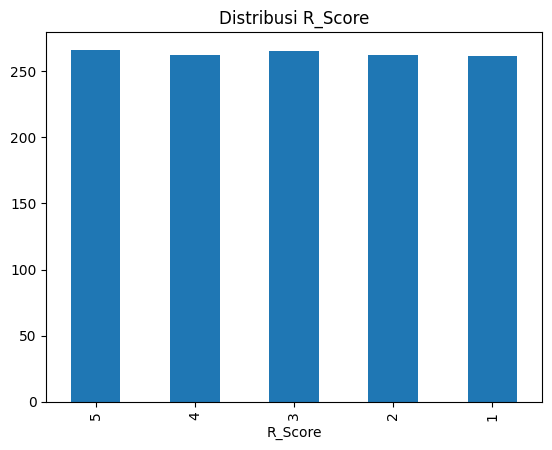

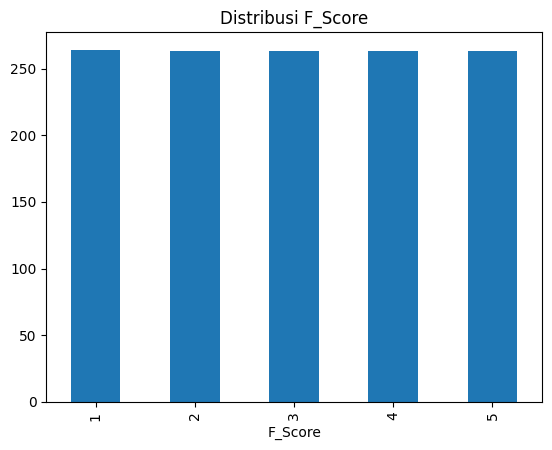

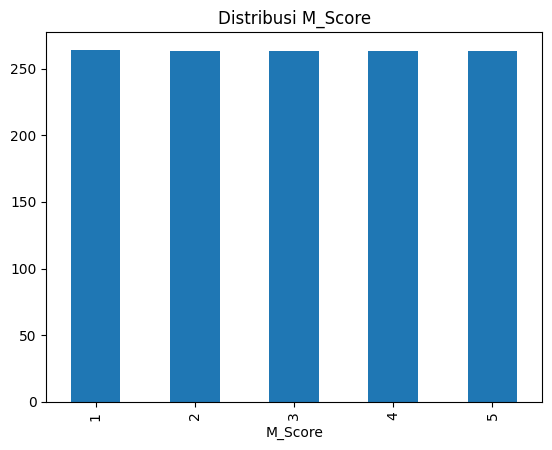

In [ ]:
import matplotlib.pyplot as plt

rfm_table['R_Score'].value_counts().sort_index().plot(kind='bar', title='Distribusi R_Score')
plt.show()
rfm_table['F_Score'].value_counts().sort_index().plot(kind='bar', title='Distribusi F_Score')
plt.show()
rfm_table['M_Score'].value_counts().sort_index().plot(kind='bar', title='Distribusi M_Score')
plt.show()

### Segmentasi & Interpretasi Hasil RFM

In [ ]:
def rfm_segment(row):
    if (int(row['R_Score']) >= 4) and (int(row['F_Score']) >= 4) and (int(row['M_Score']) >= 4):
        return 'Loyal'
    elif (
        ((int(row['R_Score']) >= 3) + (int(row['F_Score']) >= 3) + (int(row['M_Score']) >= 3)) >= 2
    ):
        return 'Biasa'
    else:
        return 'Rendah'

rfm_table['Segment'] = rfm_table.apply(rfm_segment, axis=1)

print(rfm_table['Segment'].value_counts())

Segment
Biasa     558
Rendah    514
Loyal     244
Name: count, dtype: int64


Segmentasi pelanggan dibagi menjadi tiga kelompok utama:
*   Loyal: pelanggan aktif dengan skor RFM minimal 4 (nilai 4 atau 5)
*   Biasa: pelanggan yang memiliki setidaknya dua dari tiga skor adalah 3 atau lebih
*   Rendah: pelanggan yang jarang bertransaksi atau nilai belanjanya rendah


Pembagian segmen pelanggan seperti Loyal, Biasa, dan Rendah ini dibuat supaya perusahaan bisa memahami perilaku pelanggan dengan lebih praktis dan mengambil langkah yang paling tepat untuk setiap segmen.

1. Segmen Loyal adalah pelanggan yang selalu aktif dan nilainya tinggi untuk bisnis. Segmen ini menjadi prioritas utama dalam program retensi atau loyalitas, misalnya diberikan penawaran khusus atau penghargaan, karena mereka sudah terbukti membawa keuntungan signifikan dan berpotensi besar untuk terus bertahan di masa depan.

2. Segmen Biasa mencakup pelanggan yang cukup sering berbelanja atau baru menunjukkan potensi untuk menjadi lebih loyal, Segmen ini harus diberikan perhatian oleh perusahaan agar hubungannya semakin erat dan akhirnya bisa naik kelas menjadi pelanggan Loyal.

3. Segmen Rendah adalah pelanggan yang sudah jarang bertransaksi atau nilainya kecil. Dengan mengetahui siapa saja yang masuk ke kelompok ini, perusahaan dapat merancang strategi reaktivasi, misalnya mengirimkan penawaran menarik. Dengan cara ini, perusahaan bisa menekan kemungkinan kehilangan pelanggan dan menjaga jumlah pelanggan secara keseluruhan.

In [ ]:
seg_summary = rfm_table.groupby('Segment').agg({
    'card': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'card':'Jumlah Pelanggan'})
print(seg_summary)

         Jumlah Pelanggan     Recency  Frequency    Monetary
Segment                                                     
Biasa                 558  157.333333   2.283154   73.255878
Loyal                 244   60.069672   7.209016  225.827951
Rendah                514  240.223735   1.000000   31.647432


Berikut adalah jumlah dan rata-rata RFM untuk tiap segmentasinya


*   Loyal terdiri dari 244 pelanggan dengan nilai recency yang paling rendah (rata-rata 60 hari), frekuensi transaksi tertinggi (rata-rata 7,21 kali), serta kontribusi nilai pembelian paling besar (rata-rata Rp225.827).

*   Biasa mencakup 558 pelanggan dengan perilaku yang cukup aktif, rata-rata recency 157 hari, frekuensi transaksi menengah (2,28 kali), dan nilai pembelian yang juga menengah (rata-rata Rp73.256).

*   Rendah meliputi 514 pelanggan dengan rata-rata recency tertinggi (240 hari, artinya sudah lama tidak bertransaksi), frekuensi transaksi rendah sekali (hanya 1 kali), dan nilai pembelian terkecil (rata-rata Rp31.647).








## Export hasil

In [ ]:
rfm_table = rfm_table.round(2)

In [ ]:
rfm_table.to_csv('rfm_coffee_shop.csv', index=False)

In [ ]:
from google.colab import files
files.download('rfm_coffee_shop.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>